# LSTM - vanilla

In [1]:
best_model = "best_model0_4.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


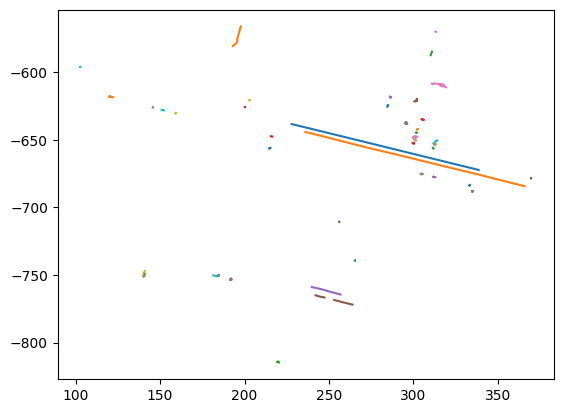

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )
        
        # print(f'x: {data_item.x.shape}')
        # print(f'y: {data_item.y.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionFusion(nn.Module):
    """
    Use attention to weight the importance of neighbor vs ego states
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),  # 2 attention weights for ego and neighbor
            nn.Softmax(dim=-1)
        )
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, ego_hidden, neighbor_hidden):
        # Concatenate for attention computation
        combined = torch.cat([ego_hidden, neighbor_hidden], dim=-1)
        attention_weights = self.attention(combined)  # (batch, 2)
        
        # Apply attention weights
        weighted_ego = ego_hidden * attention_weights[:, 0:1]
        weighted_neighbor = neighbor_hidden * attention_weights[:, 1:2]
        
        # Combine and project
        fused = weighted_ego + weighted_neighbor
        return self.output_proj(fused)

class GatedFusion(nn.Module):
    """
    Use gating mechanism to control information flow from neighbor to ego
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Gates for controlling neighbor influence
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )
        # Transform neighbor information
        self.neighbor_transform = nn.Linear(hidden_dim, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, ego_hidden, neighbor_hidden):
        # Compute gate values based on both states
        combined = torch.cat([ego_hidden, neighbor_hidden], dim=-1)
        gate_values = self.gate(combined)
        
        # Transform neighbor information
        neighbor_transformed = self.neighbor_transform(neighbor_hidden)
        
        # Apply gating: ego + gated_neighbor_influence
        fused = ego_hidden + gate_values * neighbor_transformed
        return self.output_proj(fused)

class BilinearFusion(nn.Module):
    """
    Use bilinear interaction to capture complex relationships between ego and neighbor
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Bilinear layer for interaction
        self.bilinear = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
        # Linear projections
        self.ego_proj = nn.Linear(hidden_dim, hidden_dim)
        self.neighbor_proj = nn.Linear(hidden_dim, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim * 3, hidden_dim)  # ego + neighbor + interaction
    
    def forward(self, ego_hidden, neighbor_hidden):
        # Individual projections
        ego_proj = self.ego_proj(ego_hidden)
        neighbor_proj = self.neighbor_proj(neighbor_hidden)
        
        # Bilinear interaction
        interaction = self.bilinear(ego_hidden, neighbor_hidden)
        
        # Combine all three components
        combined = torch.cat([ego_proj, neighbor_proj, interaction], dim=-1)
        return self.output_proj(combined)

class CrossAttentionFusion(nn.Module):
    """
    Use cross-attention where ego attends to neighbor and vice versa
    """
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        # Query, Key, Value projections
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
    
    def forward(self, ego_hidden, neighbor_hidden):
        batch_size = ego_hidden.size(0)
        
        # Stack ego and neighbor for multi-head attention
        states = torch.stack([ego_hidden, neighbor_hidden], dim=1)  # (batch, 2, hidden_dim)
        
        # Multi-head attention
        q = self.q_proj(states).view(batch_size, 2, self.num_heads, self.head_dim)
        k = self.k_proj(states).view(batch_size, 2, self.num_heads, self.head_dim)
        v = self.v_proj(states).view(batch_size, 2, self.num_heads, self.head_dim)
        
        q = q.transpose(1, 2)  # (batch, heads, 2, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        
        # Apply attention
        attended = torch.matmul(attn_weights, v)
        attended = attended.transpose(1, 2).contiguous().view(batch_size, 2, self.hidden_dim)
        
        # Project and take ego's attended representation
        output = self.out_proj(attended[:, 0])  # Focus on ego
        return self.layer_norm(output + ego_hidden)  # Residual connection

class SpatiallyAwareFusion(nn.Module):
    """
    Use relative spatial information to weight the fusion
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Spatial encoder for relative position/velocity
        self.spatial_encoder = nn.Sequential(
            nn.Linear(4, hidden_dim // 2),  # relative x, y, vx, vy
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)
        )
        
        # Fusion network that considers spatial context
        self.fusion_net = nn.Sequential(
            nn.Linear(hidden_dim * 2 + hidden_dim // 4, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
    
    def forward(self, ego_hidden, neighbor_hidden, relative_spatial=None):
        # If spatial info is provided, use it
        if relative_spatial is not None:
            spatial_features = self.spatial_encoder(relative_spatial)
            combined = torch.cat([ego_hidden, neighbor_hidden, spatial_features], dim=-1)
        else:
            # Fallback to simple concatenation if no spatial info
            combined = torch.cat([ego_hidden, neighbor_hidden], dim=-1)
            
        return self.fusion_net(combined)

class AdaptiveFusion(nn.Module):
    """
    Adaptive fusion that learns when to rely more on ego vs neighbor
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Meta-network to decide fusion strategy
        self.meta_net = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3),  # 3 fusion strategies
            nn.Softmax(dim=-1)
        )
        
        # Different fusion strategies
        self.attention_fusion = AttentionFusion(hidden_dim)
        self.gated_fusion = GatedFusion(hidden_dim)
        self.bilinear_fusion = BilinearFusion(hidden_dim)
    
    def forward(self, ego_hidden, neighbor_hidden):
        # Decide which fusion strategy to use
        combined = torch.cat([ego_hidden, neighbor_hidden], dim=-1)
        strategy_weights = self.meta_net(combined)  # (batch, 3)
        
        # Apply each fusion strategy
        attention_result = self.attention_fusion(ego_hidden, neighbor_hidden)
        gated_result = self.gated_fusion(ego_hidden, neighbor_hidden)
        bilinear_result = self.bilinear_fusion(ego_hidden, neighbor_hidden)
        
        # Weighted combination of strategies
        result = (strategy_weights[:, 0:1] * attention_result +
                 strategy_weights[:, 1:2] * gated_result +
                 strategy_weights[:, 2:3] * bilinear_result)
        
        return result

# Example usage in your LSTM model:
# class ImprovedLSTMModel(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2, num_layers=1, fusion_type='attention'):
#         super().__init__()
        
#         # LSTM encoders
#         self.ego_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.neighbor_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
#         # Choose fusion method
#         if fusion_type == 'attention':
#             self.fusion = AttentionFusion(hidden_dim)
#         elif fusion_type == 'gated':
#             self.fusion = GatedFusion(hidden_dim)
#         elif fusion_type == 'bilinear':
#             self.fusion = BilinearFusion(hidden_dim)
#         elif fusion_type == 'cross_attention':
#             self.fusion = CrossAttentionFusion(hidden_dim)
#         elif fusion_type == 'spatial':
#             self.fusion = SpatiallyAwareFusion(hidden_dim)
#         elif fusion_type == 'adaptive':
#             self.fusion = AdaptiveFusion(hidden_dim)
#         else:
#             # Fallback to simple concatenation
#             self.fusion = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim * 2, hidden_dim * 2),
#             # TODO: add dropout?
#             nn.ReLU(),
#             nn.Linear(hidden_dim * 2, output_dim)
#         )
    
#     def forward(self, ego_seq, neighbor_seq, relative_spatial=None):
#         # Encode sequences
#         ego_out, (ego_h, _) = self.ego_lstm(ego_seq)
#         neighbor_out, (neighbor_h, _) = self.neighbor_lstm(neighbor_seq)
        
#         # Take final hidden states
#         ego_final = ego_h[-1]  # Last layer's hidden state
#         neighbor_final = neighbor_h[-1]
        
#         # Fuse hidden states
#         if hasattr(self.fusion, 'forward') and 'relative_spatial' in self.fusion.forward.__code__.co_varnames:
#             fused = self.fusion(ego_final, neighbor_final, relative_spatial)
#         else:
#             fused = self.fusion(ego_final, neighbor_final)
        
#         # Decode to trajectory
#         trajectory = self.decoder(fused)
#         return trajectory.view(-1, pred_len, 2)

# Recommendation: Start with AttentionFusion or GatedFusion
# They're simpler but often very effective for motion forecasting

In [26]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    # 2 layers 9.77 val
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2, num_layers=1, topk = 1):
        super(SimpleLSTM, self).__init__()
        self.topk = topk
        self.hidden_dim = hidden_dim
        
        self.ego_encoder = nn.LSTM(input_size=5, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.neighbor_encoder = nn.LSTM(input_size=5, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim*(topk+1), hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        # for name, param in self.named_parameters():
        #     if 'weight' in name:
        #         nn.init.xavier_normal_(param)
        #     elif 'bias' in name:
        #         nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x[..., :5]
        x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
        batch_size = x.size(0)
        # x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        device = x.device
        
        # EGO AGENT
        ego_traj = x[:, 0, :, :]  # (batch, 50, 5)
        # Process through LSTM
        ego_lstm_out, _ = self.ego_encoder(ego_traj)
        # Extract final hidden state
        ego_hidden = ego_lstm_out[:, -1, :]
        
        # CLOSEST NEIGHBOR
        # ---- DISTANCES TO OTHER AGENTS ----
        ego_pos = x[:, 0, 49, :2].unsqueeze(1)  # (batch, 1, 2)
        agent_pos = x[:, :, 49, :2]  # (batch, 50, 2)
        dists = torch.norm(agent_pos - ego_pos, dim=-1)  # (batch, 50)
        dists[:, 0] = float('inf')  # mask out ego
        
        _, neighbor_ids = torch.topk(dists, k=self.topk, dim=1, largest=False)  # (batch, 3)
        
        # ---- ENCODE NEIGHBORS ----
        neighbor_out_list = []

        for i in range(self.topk):
            idx = neighbor_ids[:, i]  # (batch,)
            neighbor_trajs = torch.stack([x[b, idx[b], :, :5] for b in range(batch_size)], dim=0)  # (batch, 50, 5)

            neighbor_lstm_out, _ = self.neighbor_encoder(neighbor_trajs)  # both: (num_layers, batch, hidden_dim)

            neighbor_out_list.append(neighbor_lstm_out[:, -1, :])

        # ---- CONCATENATE HIDDEN AND CELL STATES ----
        # all_features = torch.cat([ego_features] + neighbor_out_list, dim=1)  # (num_layers, batch, hidden_dim * 4)
        fusion = AttentionFusion(self.hidden_dim).to(device)
        combined_hidden = fusion(ego_hidden, neighbor_lstm_out[:, -1, :]).to(device)
        
        # Process through prediction head
        features = self.relu(self.fc1(combined_hidden))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [27]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [28]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [29]:
# no scaling - better with scaling
# x, y, vx, vy only (all) - worse

# now: x, y only (neighbor) => 2 neighbors => 1.6559 val, 9.3 ps
# next: change hidden sizes to gradually descrease or make a little bit smaller because now multiplied by 3

# now 1 neighbor, x y only for neighbors, hidden sizes decreasing gradually
# now 1 neighbor, x y vx vy only for neighbors, hidden sizes decreasing gradually

# now: 1 neighbor - hidden sizes decreasing
# next: decrease hidden sizes more?

# 3 neighbors, 2, 1

# next 3: x, y, vx, vy only (ego)
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_15649/1407810273.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (32x512 and 1024x512)

# Final Pred

In [74]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto_1neighb_dec_hidden_size.csv', index=True)
# output_df.to_csv('submission_lstm_simple_auto8_largerhidden.csv', index=True)

: 